In [1]:
import torch
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

# Đảm bảo reproducibility
torch.manual_seed(1)

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {device}")


✅ Using device: cuda


1 Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/sea-animals-image-dataste")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sea-animals-image-dataste


In [3]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.75, scale=(0.01, 0.3), ratio=(1.0, 1.0), value=0, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
data_path = path

full_dataset = datasets.ImageFolder(data_path, transform=None)

# Split 80/20
train_len = int(0.8 * len(full_dataset))
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_len, test_len])

# Wrapper để áp transform khác nhau sau khi split
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_data = TransformDataset(train_dataset, train_transform)
test_data = TransformDataset(test_dataset, test_transform)

# DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

print(f"✅ Dataset loaded: {len(train_data)} training samples, {len(test_data)} validation samples.")


✅ Dataset loaded: 10968 training samples, 2743 validation samples.


In [4]:
class_names = full_dataset.classes
print(f"🔍 Có {len(class_names)} lớp: {class_names}")

🔍 Có 23 lớp: ['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


2 Model

In [5]:
# Load the pretrained Resnet50 model
resnet50 = models.resnet50(weights=models.ResNeXt50_32X4D_Weights)

# Replace the fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
                            nn.Dropout(0.3),
                            nn.Linear(num_ftrs, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 23)   # số lớp của bạn
                            )

model = resnet50

model.to(device)
summary(model, (3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

3 Train, Evaluate

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [7]:
def train_one_epoch(model, criterion, optimizer, loader):
    model.train()
    total, running_loss, running_correct = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

def evaluate_one_epoch(model, criterion, loader):
    model.eval()
    total, test_loss, running_correct = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = test_loss / len(loader)
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


In [8]:
# Training loop
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

num_epochs = 20

print("⚙️ Starting training...", flush=True)

for epoch in range(num_epochs):

    train_loss, train_acc = train_one_epoch(model, criterion, optimizer, train_loader)
    test_loss, test_acc = evaluate_one_epoch(model, criterion, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"[Epoch {epoch+1:02d}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} || "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} || ",

          flush=True)

print("✅ Training completed.", flush=True)

⚙️ Starting training...
[Epoch 01/20] Train Loss: 1.3743 | Train Acc: 0.6033 || Test Loss: 0.7249 | Test Acc: 0.7816 || 
[Epoch 02/20] Train Loss: 0.6419 | Train Acc: 0.8142 || Test Loss: 0.5917 | Test Acc: 0.8265 || 
[Epoch 03/20] Train Loss: 0.4414 | Train Acc: 0.8692 || Test Loss: 0.5571 | Test Acc: 0.8414 || 
[Epoch 04/20] Train Loss: 0.3473 | Train Acc: 0.8968 || Test Loss: 0.6116 | Test Acc: 0.8410 || 
[Epoch 05/20] Train Loss: 0.2789 | Train Acc: 0.9156 || Test Loss: 0.6493 | Test Acc: 0.8349 || 
[Epoch 06/20] Train Loss: 0.2280 | Train Acc: 0.9321 || Test Loss: 0.6244 | Test Acc: 0.8389 || 
[Epoch 07/20] Train Loss: 0.2016 | Train Acc: 0.9392 || Test Loss: 0.6868 | Test Acc: 0.8381 || 
[Epoch 08/20] Train Loss: 0.1774 | Train Acc: 0.9468 || Test Loss: 0.6725 | Test Acc: 0.8327 || 
[Epoch 09/20] Train Loss: 0.1699 | Train Acc: 0.9484 || Test Loss: 0.7549 | Test Acc: 0.8345 || 
[Epoch 10/20] Train Loss: 0.1605 | Train Acc: 0.9513 || Test Loss: 0.7300 | Test Acc: 0.8312 || 
[Epoch

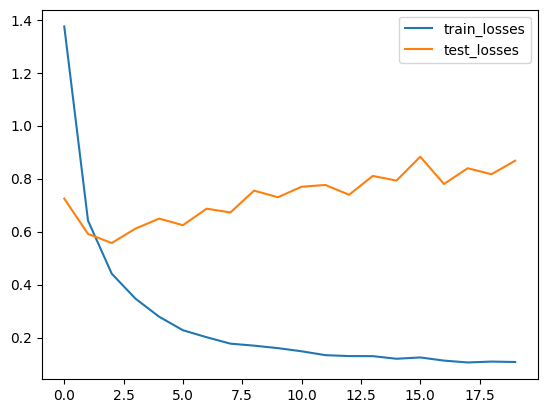

In [9]:
plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

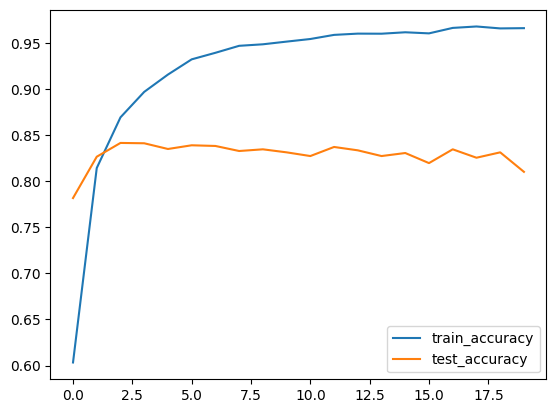

In [10]:
plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()
print("Cache cleared.")

Cache cleared.


Hiển thị 10 ảnh ngẫu nhiên từ tập kiểm thử:


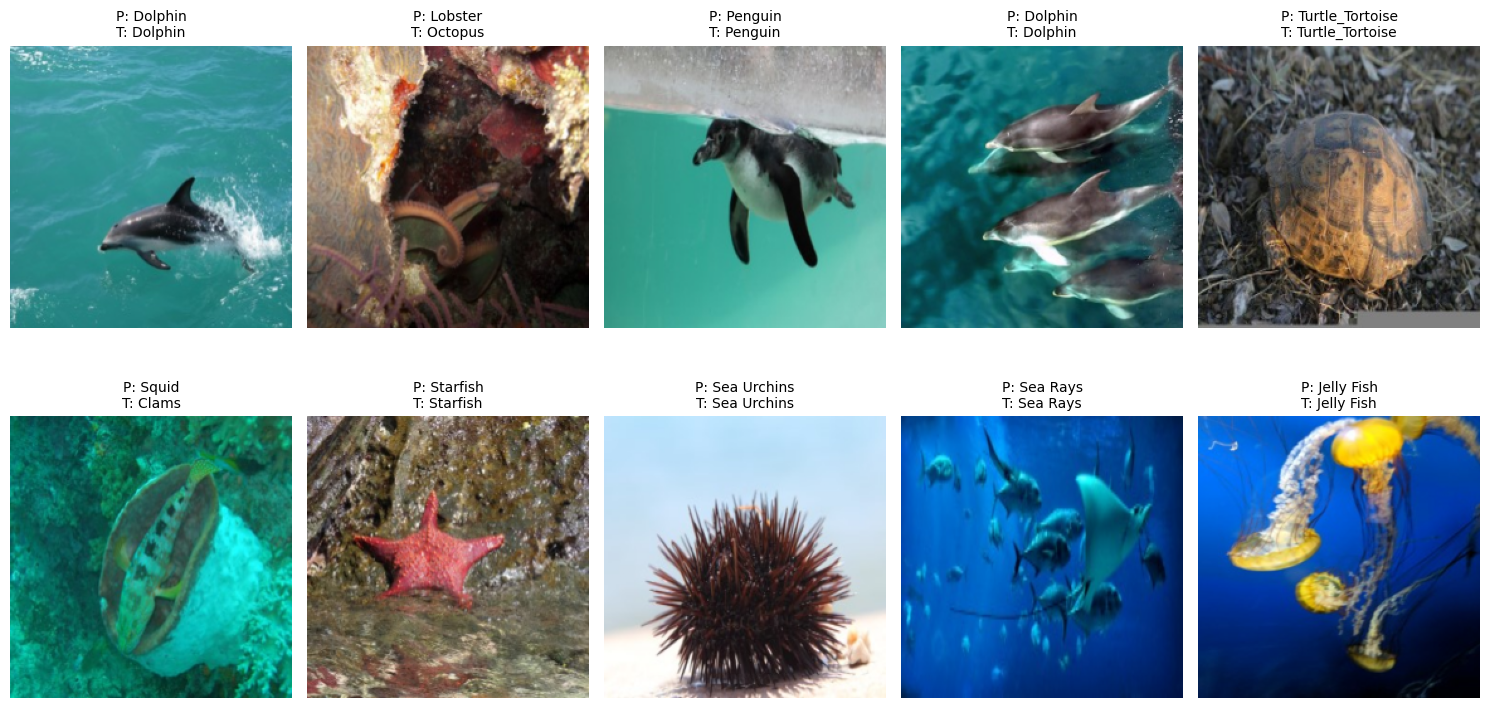

In [11]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Number of random samples to display
num_samples_to_display = 10
random_indices = random.sample(range(len(test_data)), num_samples_to_display)

print(f"Hiển thị {num_samples_to_display} ảnh ngẫu nhiên từ tập kiểm thử:")

# Function to unnormalize images for displaying
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

plt.figure(figsize=(15, 8))

for i, data_index in enumerate(random_indices):
    # Get the image and true label from the test dataset
    image_tensor, true_label_idx = test_data[data_index]
    true_label = class_names[true_label_idx]

    # Make a prediction
    model.eval()
    with torch.no_grad():
        image_input = image_tensor.unsqueeze(0).to(device)
        outputs = model(image_input)
        _, predicted_label_idx = torch.max(outputs, 1)
        predicted_label = class_names[predicted_label_idx.item()]

    # Unnormalize and convert to numpy for displaying
    image_display = unnormalize(image_tensor.clone(), mean, std)
    image_display = image_display.permute(1, 2, 0).cpu().numpy()
    image_display = np.clip(image_display, 0, 1) # Clip values to be between 0 and 1

    # Display the image and prediction
    plt.subplot(2, 5, i + 1) # Arrange images in 2 rows, 5 columns
    plt.imshow(image_display)
    plt.title(f"P: {predicted_label}\nT: {true_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
# Define the path to save the model
model_save_path = "/content/drive/MyDrive/Colab Notebooks/Pretraining_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"✅ Model saved to: {model_save_path}")

✅ Model saved to: /content/drive/MyDrive/Colab Notebooks/Pretraining_model.pth
